#AI In Industry Project
###team members:
#####Parsa Mastouri Kashani
#####Freddy Fernandes
#####Arina Sadeghi Khiabanian

##SYSTEM SETUP

In [1]:
!nvidia-smi

Tue Mar 19 17:53:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

##Downloading the dataset(ECG)

In [2]:
!gdown https://www.timeseriesclassification.com/aeon-toolkit/ECG5000.zip

Downloading...
From: https://www.timeseriesclassification.com/aeon-toolkit/ECG5000.zip
To: /content/ECG5000.zip
100% 10.6M/10.6M [00:01<00:00, 8.06MB/s]


##Unzipping the dataset file

In [3]:
!unzip ECG5000.zip

Archive:  ECG5000.zip
  inflating: ECG5000.txt             
  inflating: ECG5000_TEST.arff       
  inflating: ECG5000_TEST.txt        
  inflating: ECG5000_TRAIN.arff      
  inflating: ECG5000_TRAIN.txt       
  inflating: ECG5000_TEST.ts         
  inflating: ECG5000_TRAIN.ts        


##Importing Necessary Libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import seaborn as sns
import os

## 1. Data Loading and Preprocessing

In [5]:
from scipy.io.arff import loadarff
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from glob import glob
import time
import copy
import shutil
import seaborn as sns
import numpy as np
import torch
import pandas as pd

from torch import nn, optim


from matplotlib import pyplot as plt
import torch.nn.functional as F
from torchvision import datasets, transforms, models

## Configure plotting, set hyperparameters, and define device for PyTorch.

In [6]:
%matplotlib inline
%config InlineBackend.figure_format="retina"

sns.set(style="whitegrid", palette="muted", font_scale=1.2)

plt.rcParams["figure.figsize"] = 12, 8

BATCH_SIZE = 16
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load training data and test data from ECG files.


In [7]:
with open("ECG5000_TRAIN.arff") as f:
  data, _ = loadarff(f)
  train = pd.DataFrame(data)

with open("ECG5000_TEST.arff") as f:
  data, _ = loadarff(f)
  test = pd.DataFrame(data)

In [8]:
df =train.append(test)
df=df.sample(frac=1.0)

<ipython-input-8-13b449d30a65>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df =train.append(test)


In [9]:
df.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
1001,1.469756,-1.048520,-3.394356,-4.254399,-4.162834,-3.822570,-3.003609,-1.799773,-1.500033,-1.025095,...,0.945178,1.275588,1.617218,1.580279,1.306195,1.351674,1.915517,1.672103,-1.039932,b'1'
2086,-1.998602,-3.770552,-4.267091,-4.256133,-3.515288,-2.554540,-1.699639,-1.566366,-1.038815,-0.425483,...,1.008577,1.024698,1.051141,1.015352,0.988475,1.050191,1.089509,1.465382,0.799517,b'1'
2153,-1.187772,-3.365038,-3.695653,-4.094781,-3.992549,-3.425381,-2.057643,-1.277729,-1.307397,-0.623098,...,1.085007,1.467196,1.413850,1.283822,0.923126,0.759235,0.932364,1.216265,-0.824489,b'1'
555,0.604969,-1.671363,-3.236131,-3.966465,-4.067820,-3.551897,-2.582864,-1.804755,-1.688151,-1.025897,...,0.545222,0.649363,0.986846,1.234495,1.280039,1.215985,1.617971,2.196543,0.023843,b'1'
205,-1.197203,-3.270123,-3.778723,-3.977574,-3.405060,-2.392634,-1.726322,-1.572748,-0.920075,-0.388731,...,0.828168,0.914338,1.063077,1.393479,1.469756,1.392281,1.144732,1.668263,1.734676,b'1'


## Display unique values in the "target" column

In [10]:
df["target"].unique()

array([b'1', b'3', b'2', b'4', b'5'], dtype=object)

In [11]:
import pandas as pd

# Assuming df is your DataFrame
# First, convert the column to string type
df['target'] = df['target'].astype(str)

# Then replace the values
df['target'] = df['target'].replace({'b\'1\'': '0', 'b\'2\'': '1', 'b\'3\'': '1', 'b\'4\'': '1', 'b\'5\'': '1'})

# Finally, convert the column back to integer type if needed
df['target'] = df['target'].astype(int)

In [12]:
df["target"].unique()

array([0, 1])

##Data Splitting

In [13]:
training_df, test_df = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
print(len(training_df))
print(len(test_df))

training_df = np.array(training_df)
test_df = np.array(test_df)

X_train, y_train = training_df[:, :-1], training_df[:, -1]
X_test, y_test = test_df[:, :-1], test_df[:, -1]

4000
1000


This code loads ECG (Electrocardiogram) data from two ARFF files, one for training and one for testing,combines them into a single DataFrame, shuffles the rows, and preprocesses the 'target' column by converting it to string type, replacing specific values, and then converting it back to integer type if needed.
It then plots the ECG signals with anomalies detected by Isolation Forest, with different colors representing
different anomaly levels, and prints a message indicating that normal samples are shown in blue.


<ipython-input-14-3c859b4aa6e4>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df =train.append(test)


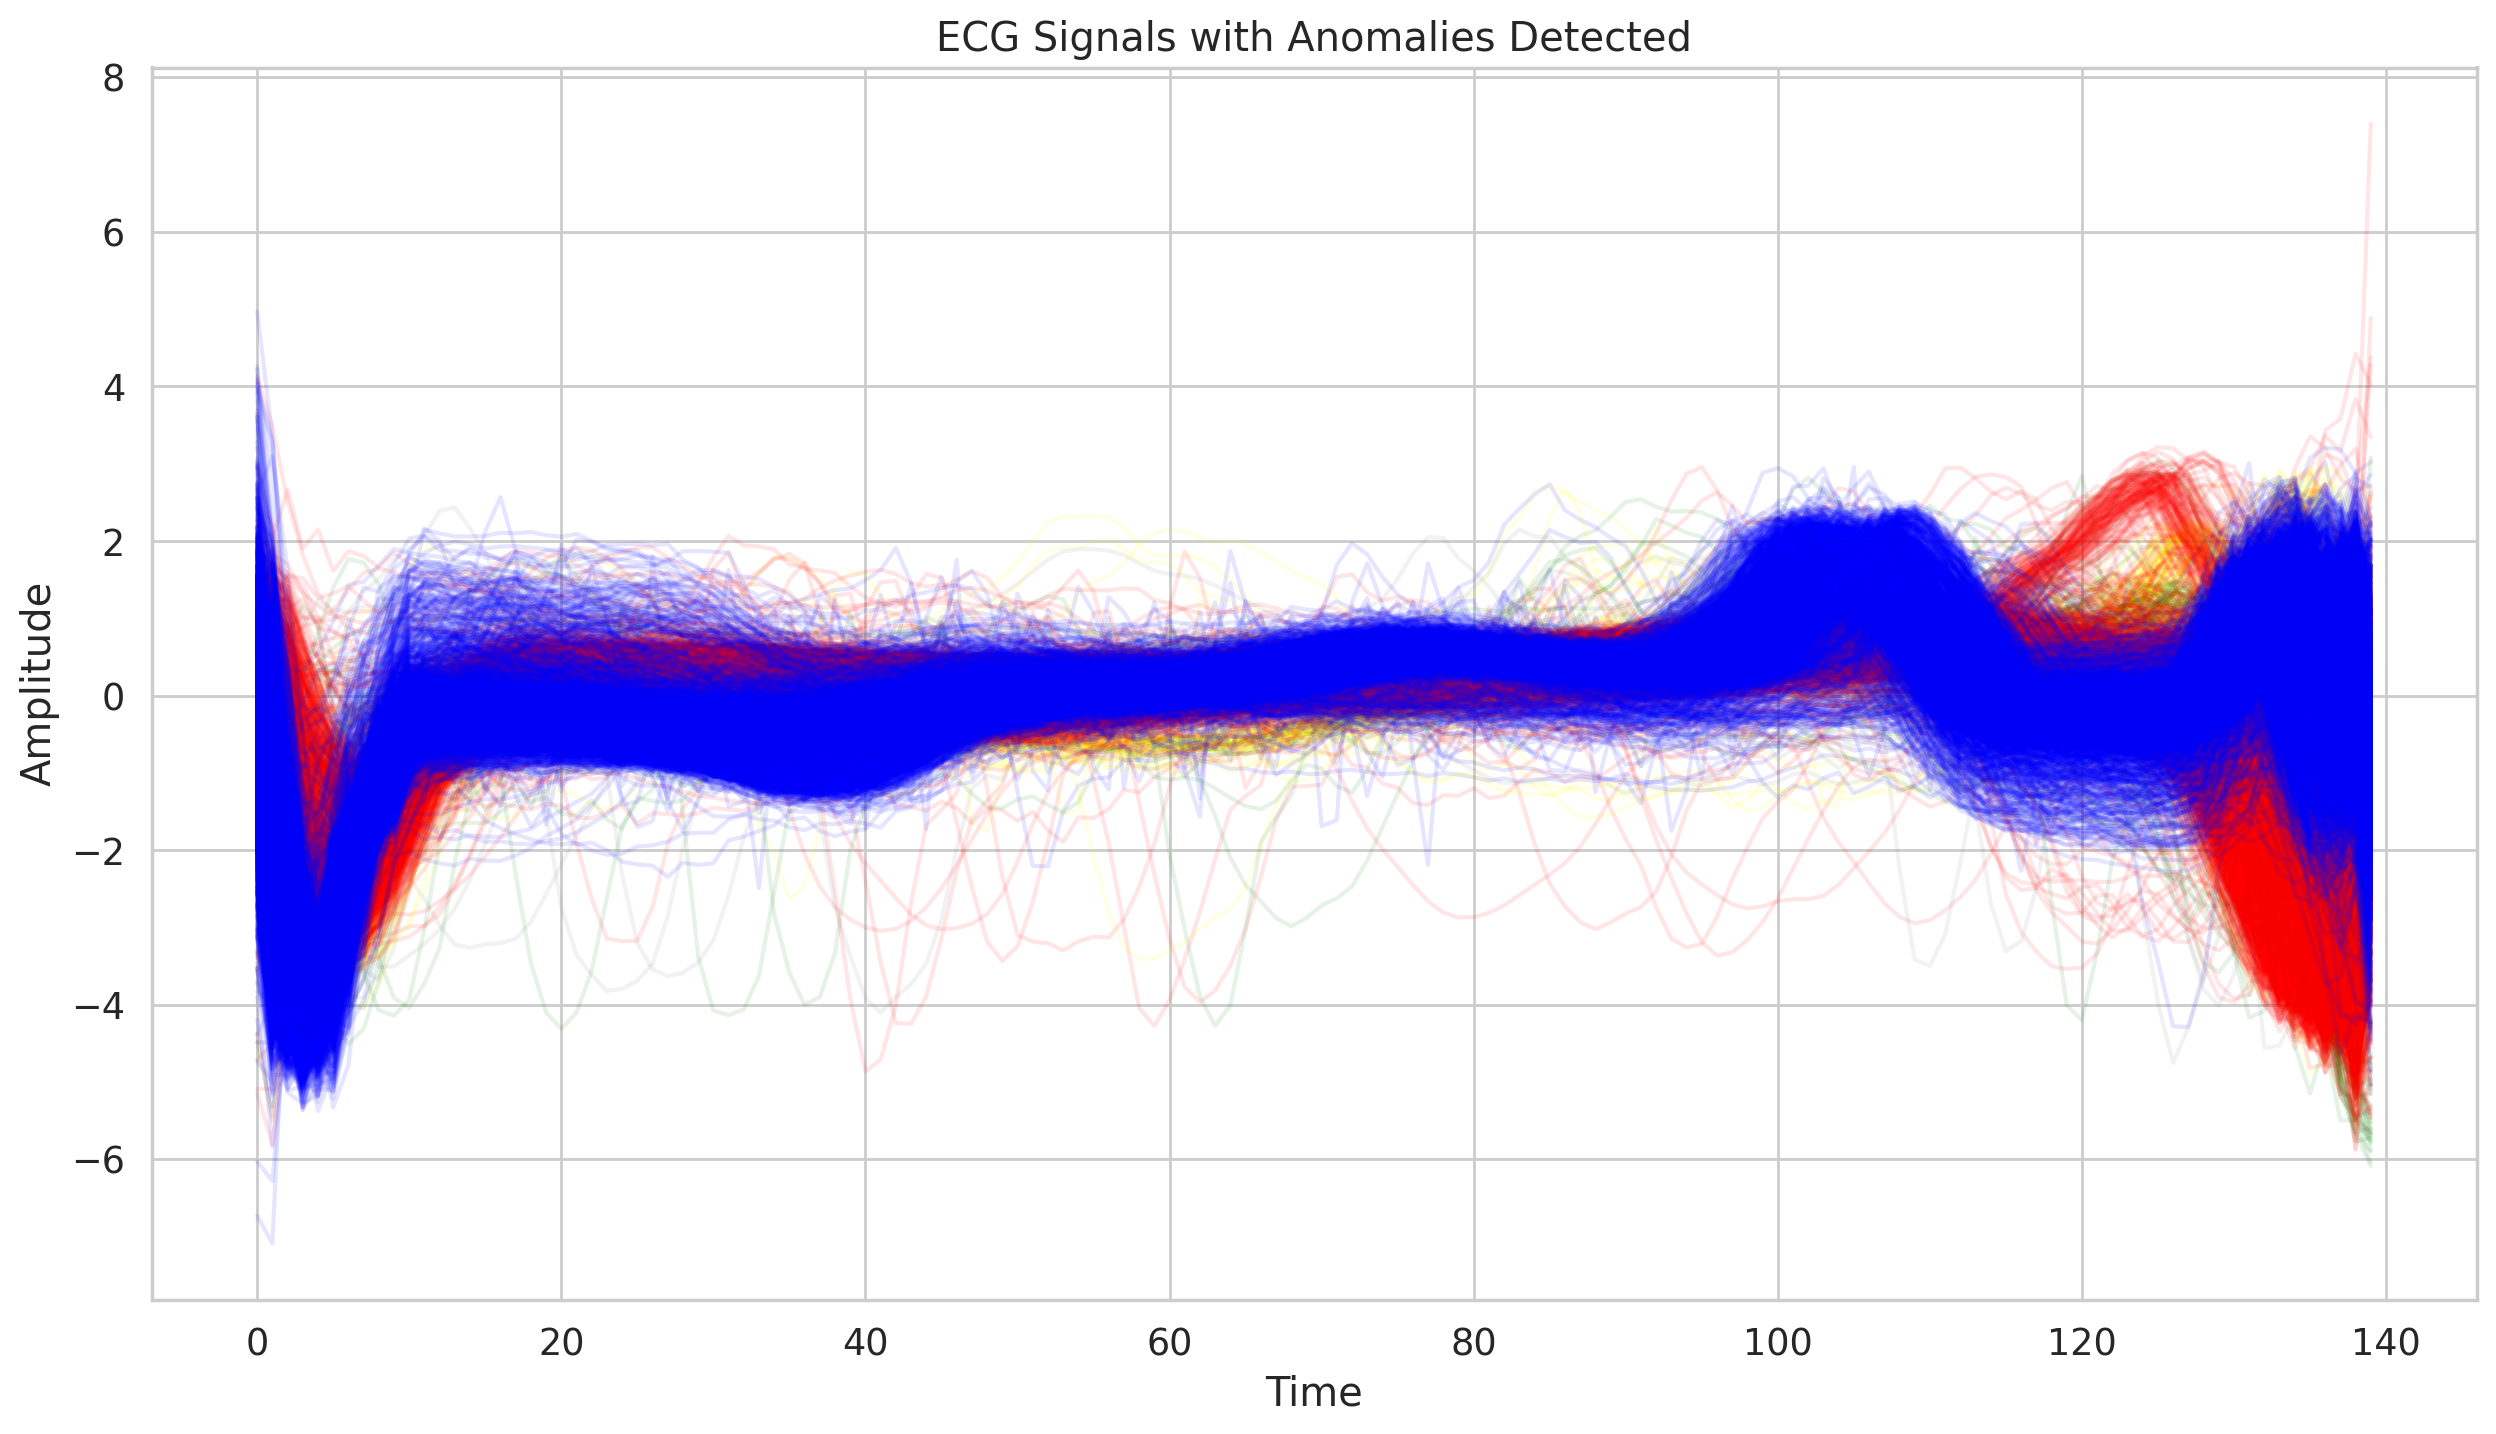

Normal samples are shown in blue


In [14]:
with open("ECG5000_TRAIN.arff") as f:
  data, _ = loadarff(f)
  train = pd.DataFrame(data)

with open("ECG5000_TEST.arff") as f:
  data, _ = loadarff(f)
  test = pd.DataFrame(data)

df =train.append(test)
df=df.sample(frac=1.0)

import pandas as pd

# Assuming df is your DataFrame
# First, convert the column to string type
df['target'] = df['target'].astype(str)

# Then replace the values
df['target'] = df['target'].replace({'b\'1\'': '0', 'b\'2\'': '1', 'b\'3\'': '2', 'b\'4\'': '3', 'b\'5\'': '4'})

# Finally, convert the column back to integer type if needed
df['target'] = df['target'].astype(int)


plot_df = np.array(df)
X_plot = plot_df[:, :-1]
y_plot = plot_df[:, -1]


# Plot ECG signals with anomalies detected
plt.figure(figsize=(15, 8))
plt.plot(X_plot[y_plot == 4].T, color='gray', alpha=0.1)  # Anomalies in red
plt.plot(X_plot[y_plot == 3].T, color='yellow', alpha=0.1)  # Anomalies in red
plt.plot(X_plot[y_plot == 2].T, color='green', alpha=0.1)  # Anomalies in red
plt.plot(X_plot[y_plot == 1].T, color='red', alpha=0.1)  # Anomalies in red
plt.plot(X_plot[y_plot == 0].T, color='blue', alpha=0.1)  # Normal data in blue
plt.title('ECG Signals with Anomalies Detected')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

print("Normal samples are shown in blue")

##Model
This code demonstrates the training and evaluation process of the XGBoost model for binary classification, including the computation of various evaluation metrics such as AUC, accuracy, precision, and recall.

In [15]:
import numpy as np
import xgboost as xgb

# Assuming you have your dataset X and labels y
# X is your dataset with shape (num_samples, num_features)
# y is your labels with shape (num_samples,)
# Assuming class 1 represents normal samples and other classes represent anomalies

# Convert labels to binary where 1 represents anomalies and 0 represents normal samples
#y_binary = np.where(y == 1, 0, 1)

# Train the XGBoost model
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 3,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

num_round = 100
dtrain = xgb.DMatrix(X_train, label=y_train)
model = xgb.train(params, dtrain, num_round)

# Make predictions on the test set
dtest = xgb.DMatrix(X_test)
y_pred_proba = model.predict(dtest)

# Evaluate the model
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
auc = roc_auc_score(y_test, y_pred_proba)
print("AUC:", auc)

# You can adjust the threshold for classifying anomalies based on your requirements
threshold = 0.5
y_pred = (y_pred_proba >= threshold).astype(int)

# Calculate other evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

AUC: 0.9974922422616305
Accuracy: 0.987
Precision: 0.9883177570093458
Recall: 0.9814385150812065


##visualization

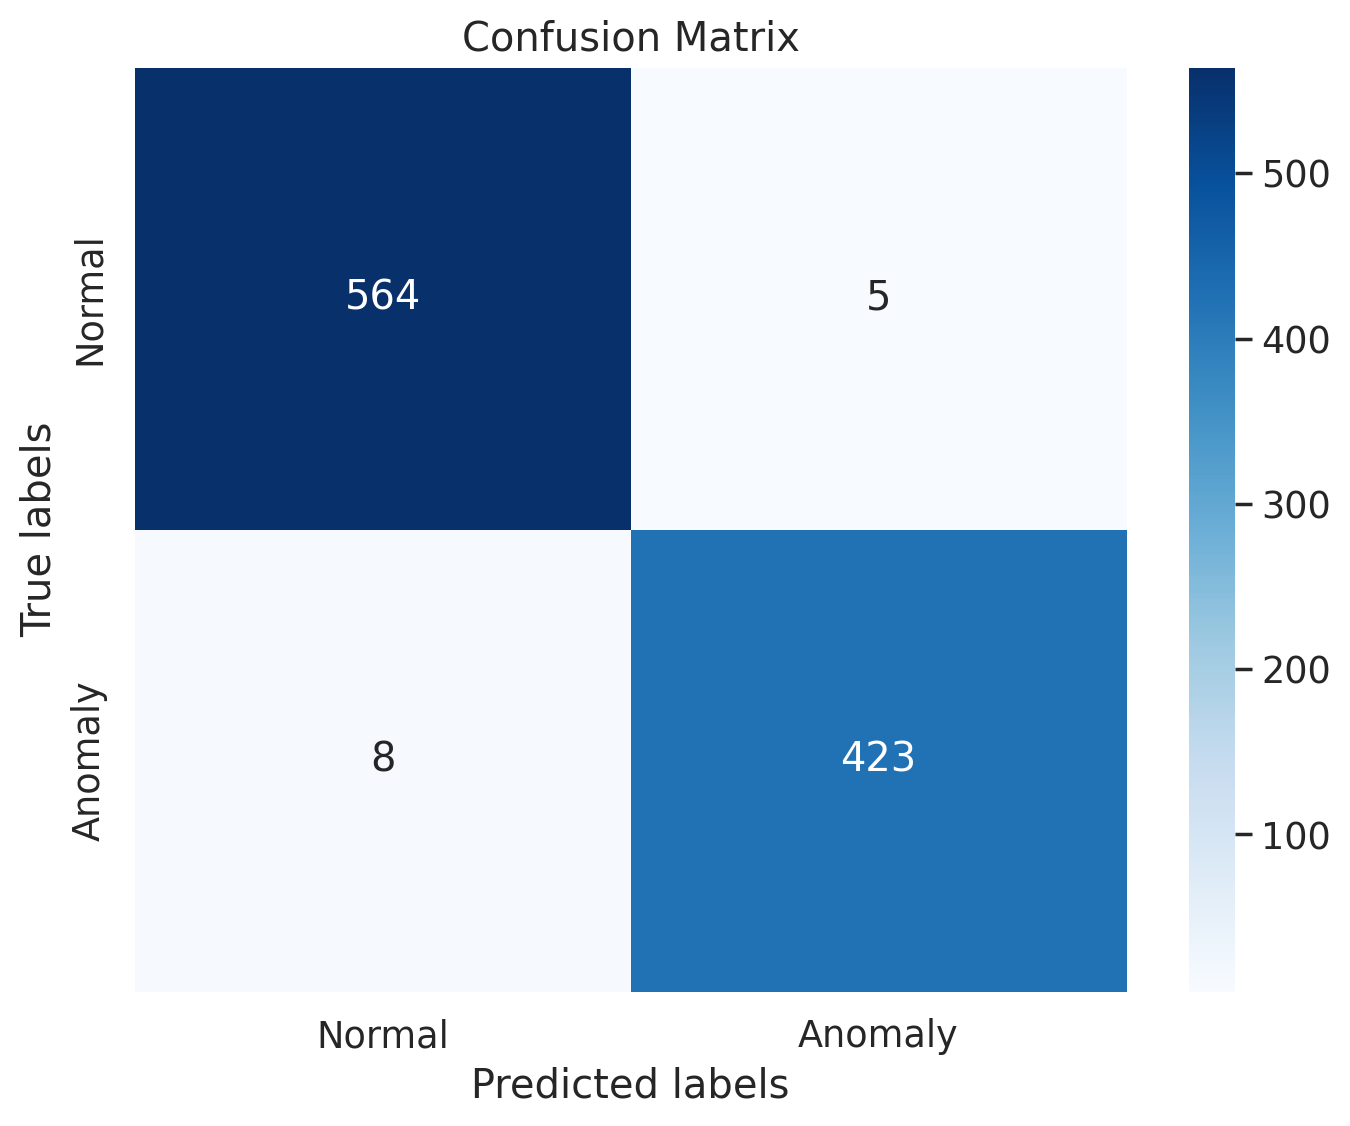

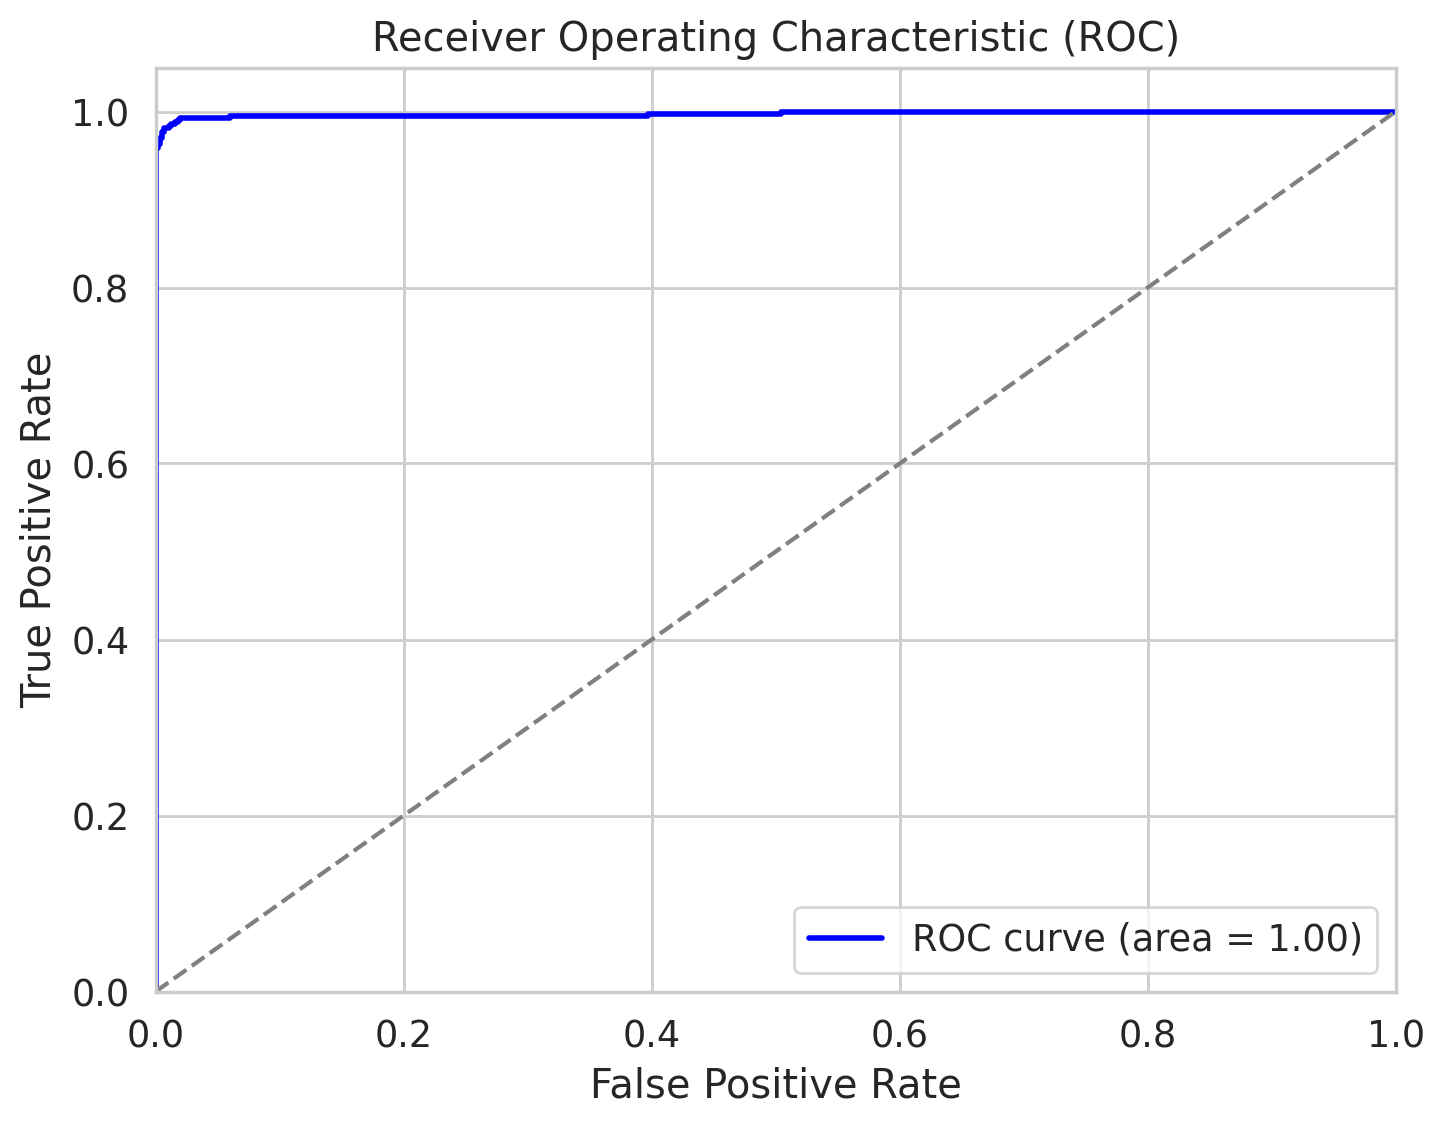

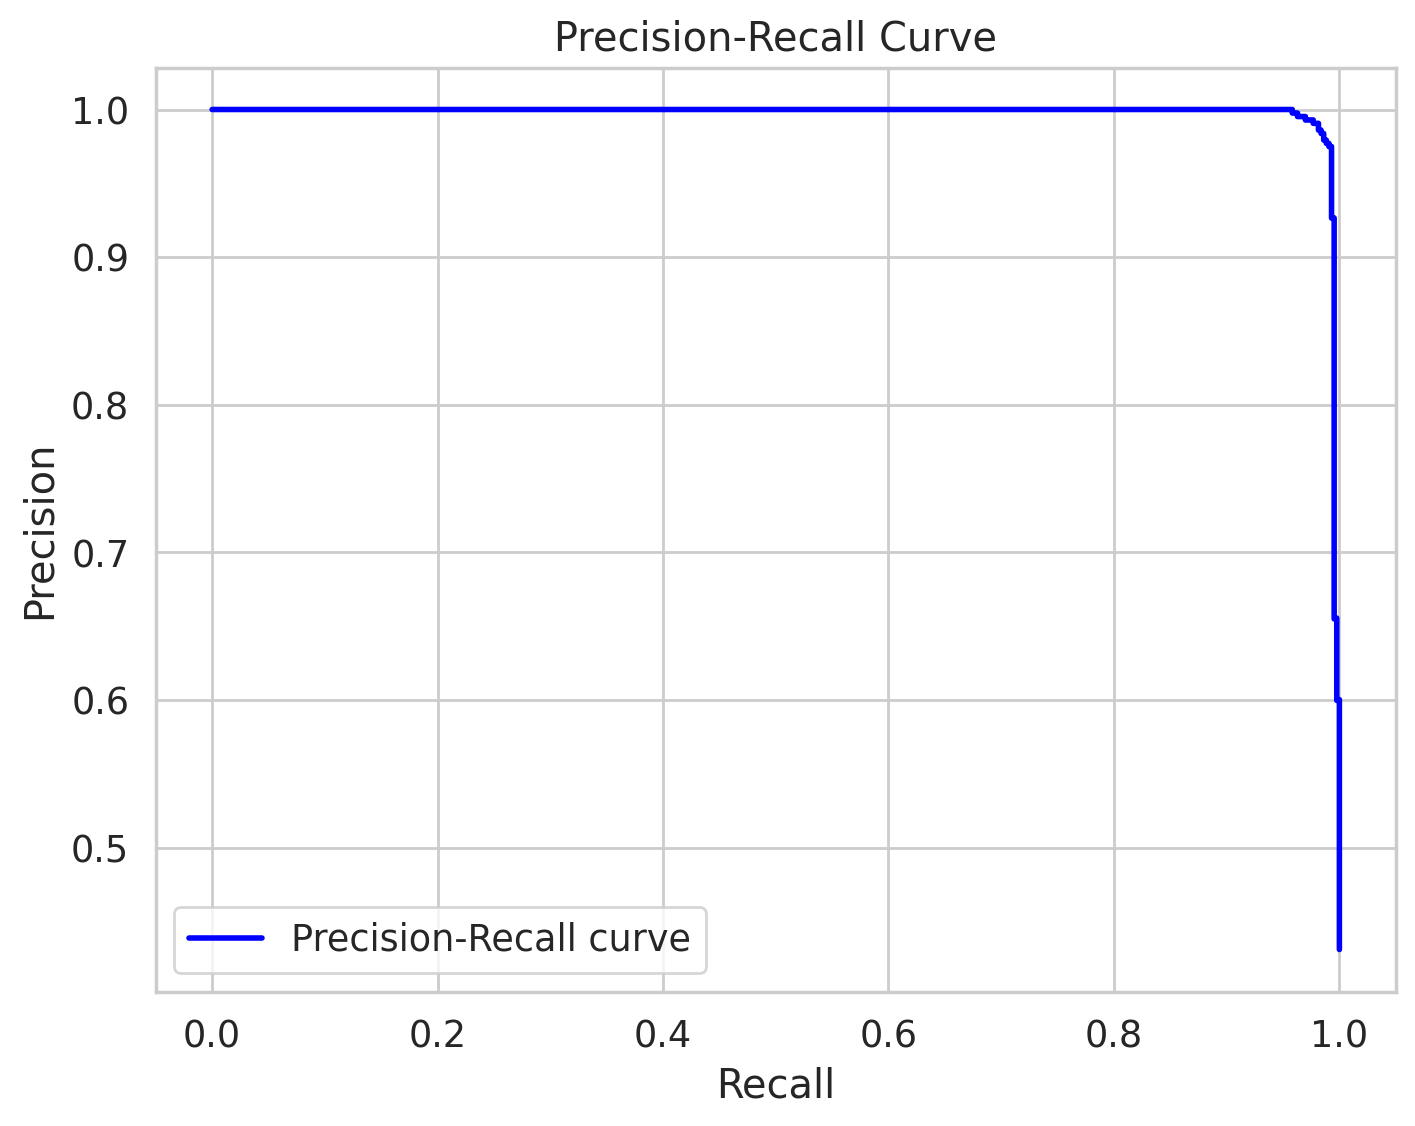

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# ROC curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Precision-recall curve
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()
